# EX02 : Definition of a metric

- Rappeler la consigne
- Expliquer le choix des library

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
from typing import Dict, Any

In [15]:
# loading the dataset
dataset = pd.read_csv('dataset.csv')

### This section is to gather some understanding about the dataset distribution :

- explain the use of gathering info on the dataset...

In [19]:
# display the first few row
dataset.head()

,Unnamed: 0,age,height,job,city,favorite music style
0,0,0.542122,0.467303,designer,paris,trap
1,1,0.477207,0.261872,fireman,marseille,hiphop
2,2,0.597165,0.508966,teacher,paris,metal
3,3,0.440277,0.252712,designer,toulouse,metal
4,4,0.462637,0.547991,teacher,paris,metal


In [20]:
# describe some info about numerical distribution
dataset.describe()

,Unnamed: 0,age,height
count,200.000000,200.000000,200.000000
mean,99.500000,0.538594,0.446563
std,57.879185,0.160581,0.153597
min,0.000000,0.000000,0.000000
25%,49.750000,0.432797,0.344444
50%,99.500000,0.529348,0.433321
75%,149.250000,0.655575,0.543402
max,199.000000,1.000000,1.000000


## Preprocessing and normalization of the data

- Expliquer pourquoi normaliser ...

In [21]:
"""
Let's initialize the scaler using ...
"""
scaler = MinMaxScaler()

# Apply the scaler to the numerical columns of the data
numerical_features = ['age', 'height'] 
dataset[numerical_features] = scaler.fit_transform(dataset[numerical_features])

dataset.head()

,Unnamed: 0,age,height,job,city,favorite music style
0,0,0.542122,0.467303,designer,paris,trap
1,1,0.477207,0.261872,fireman,marseille,hiphop
2,2,0.597165,0.508966,teacher,paris,metal
3,3,0.440277,0.252712,designer,toulouse,metal
4,4,0.462637,0.547991,teacher,paris,metal


### Handling Categorical Data

- `job`, `city`: Plan to use one-hot encoding as these are nominal categories without intrinsic order.
- `favorite music style`: Considering a custom encoding strategy to capture the similarity between different music genres based on domain knowledge.

## Defining the custom dissimilarity metric

We should isolate the different kind of styles that appears at once in the dataset

In [25]:

unique_music_styles = dataset['favorite music style'].unique()
print(unique_music_styles)


['trap' 'hiphop' 'metal' 'rock' 'rap' 'classical' 'other' 'jazz'
 'technical death metal']


------
From now on we can focus on defining a weight relationship between all of the different music style : base on a scale of 0 to 1, closer to one meaning the dissimilarity is higher.  

-----

In [29]:
genre_dissimilarity = {
    "trap": {"hiphop": 0.1, "rap": 0.2, "metal": 0.8, "rock": 0.7, "classical": 0.9, "jazz": 0.8, "technical death metal": 0.85, "other": 0.5},
    "hiphop": {"trap": 0.1, "rap": 0.1, "metal": 0.8, "rock": 0.7, "classical": 0.9, "jazz": 0.8, "technical death metal": 0.85, "other": 0.5},
    "rap": {"trap": 0.2, "hiphop": 0.1, "metal": 0.8, "rock": 0.7, "classical": 0.9, "jazz": 0.8, "technical death metal": 0.85, "other": 0.5},
    "metal": {"trap": 0.8, "hiphop": 0.8, "rap": 0.8, "rock": 0.4, "classical": 0.7, "jazz": 0.6, "technical death metal": 0.1, "other": 0.5},
    "rock": {"trap": 0.7, "hiphop": 0.7, "rap": 0.7, "metal": 0.4, "classical": 0.6, "jazz": 0.5, "technical death metal": 0.45, "other": 0.5},
    "classical": {"trap": 0.9, "hiphop": 0.9, "rap": 0.9, "metal": 0.7, "rock": 0.6, "jazz": 0.4, "technical death metal": 0.75, "other": 0.5},
    "jazz": {"trap": 0.8, "hiphop": 0.8, "rap": 0.8, "metal": 0.6, "rock": 0.5, "classical": 0.4, "technical death metal": 0.65, "other": 0.5},
    "technical death metal": {"trap": 0.85, "hiphop": 0.85, "rap": 0.85, "metal": 0.1, "rock": 0.45, "classical": 0.75, "jazz": 0.65, "other": 0.5},
    "other": {"trap": 0.5, "hiphop": 0.5, "rap": 0.5, "metal": 0.5, "rock": 0.5, "classical": 0.5, "jazz": 0.5, "technical death metal": 0.5},
}

def music_style_dissimilarity(style1: str, style2: str) -> float:
    # Direct lookup from the predefined matrix, defaulting to maximum dissimilarity (1.0)
    return genre_dissimilarity.get(style1, {}).get(style2, 1.0)



In [66]:
"""
custom_dissimilarity(): 

parameters
sample1 -> Dict
sample2:
weight_numerical:
weight_categorical:
weight_music_style:

return:

"""
def custom_dissimilarity(sample1: Dict[str, Any], sample2: Dict[str, Any], 
                         weight_numerical: float = 1.0, weight_categorical: float = 0.5,
                         weight_music_style: float = 0.5) -> float:
    dissimilarity = 0.0
    
    # Calculate dissimilarity for numerical features
    for feature in ['age', 'height']:  # Adjust based on your dataset
        diff = sample1[feature] - sample2[feature]
        dissimilarity += (diff * diff) * weight_numerical
    
    # Handling categorical features (job and city for now)
    categorical_features = ['job', 'city']
    for feature in categorical_features:
        if sample1[feature] != sample2[feature]:
            dissimilarity += weight_categorical
    
    # Handling 'favorite music style' with the previously defined function
    music_style_diff = music_style_dissimilarity(sample1['favorite music style'], sample2['favorite music style'])
    dissimilarity += music_style_diff * weight_music_style
    
    return np.sqrt(dissimilarity)

-----
Now let's produce the dissimilarity matrix

-----

In [67]:
def compute_dissimilarity_matrix(dataset):
    num_samples = len(dataset)
    dissimilarity_matrix = np.zeros((num_samples, num_samples))

    for i in range(num_samples):
        for j in range(i, num_samples):  # Optimizing by not recalculating symmetrical values
            sample1 = dataset.iloc[i].to_dict()
            sample2 = dataset.iloc[j].to_dict()
            dissimilarity = custom_dissimilarity(sample1, sample2)
            dissimilarity_matrix[i, j] = dissimilarity
            dissimilarity_matrix[j, i] = dissimilarity  # Symmetrical property

    return dissimilarity_matrix

# Compute the dissimilarity matrix
dissimilarity_matrix = compute_dissimilarity_matrix(dataset)
np.save('dissimilarity_matrix.npy', dissimilarity_matrix)


----
Let's load the matrix and look at it !

----

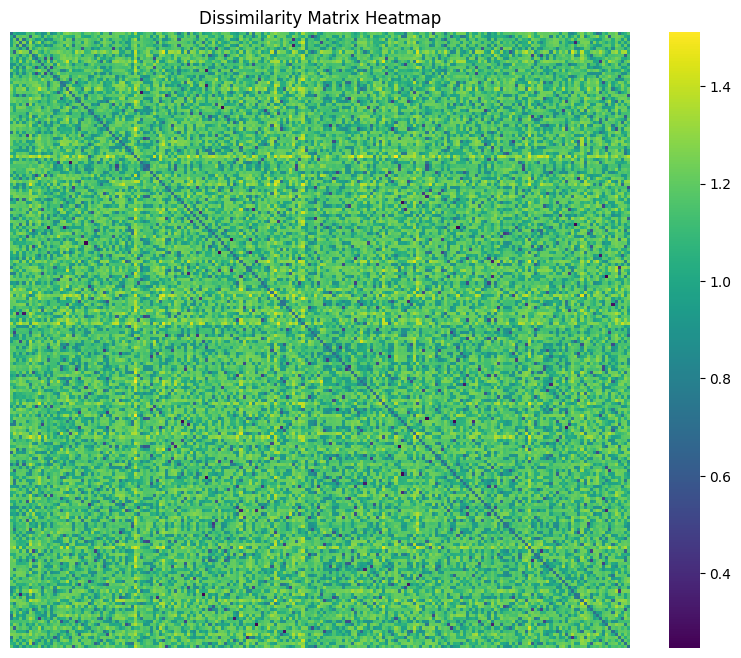

In [68]:
dissimilarity_matrix = np.load('dissimilarity_matrix.npy')
#print(dissimilarity_matrix[:10, :10])  # Adjust indices based on your dataset size


# HEATMAP

plt.figure(figsize=(10, 8))
sns.heatmap(dissimilarity_matrix, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Dissimilarity Matrix Heatmap')
plt.show()

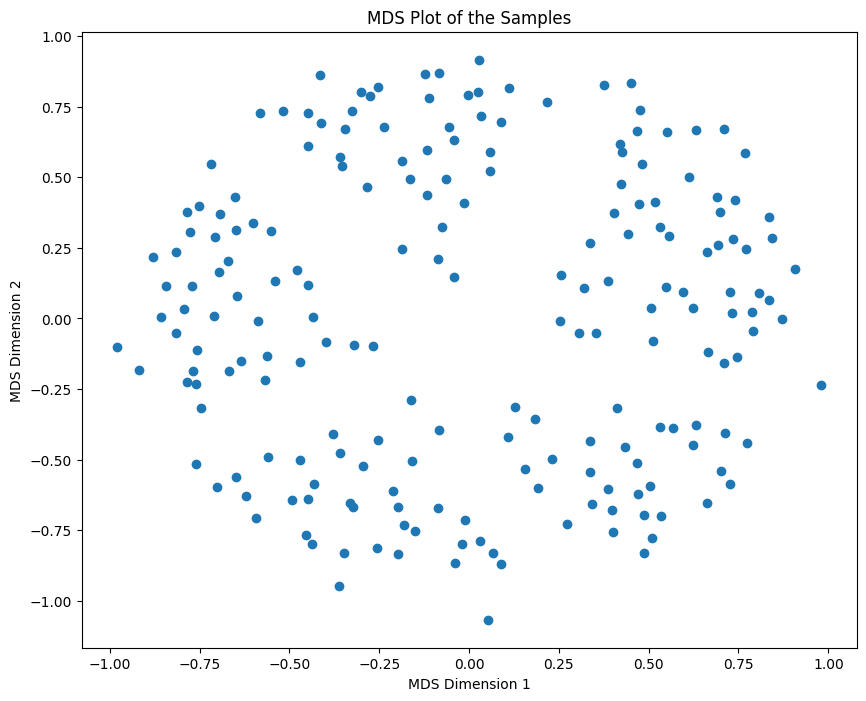

In [69]:
# MDS STUFFS
mds = MDS(n_components=2, dissimilarity="precomputed")
mds_coords = mds.fit_transform(dissimilarity_matrix)  # Fit and transform the dissimilarity matrix
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1])
plt.title("MDS Plot of the Samples")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.show()

### 